This notebook will test the basic workflow of using generative AI to predict species.
We will try to limit the number of API calls used to a minimum.
We'll use the Gemini Flash line of models to generate species names.

In [1]:
%load_ext autoreload
%autoreload 2

import dotenv
import os

dotenv.load_dotenv("../.env")
assert os.getenv("OPENROUTER_API_KEY")

FungiCLEF25-SAMPLE_SUBMISSION.csv  captions  images  metadata


(7819, 31)

(1911, 19)

eventDate: '2023-01-10'
year: 2023.0
month: 1.0
day: 10.0
habitat: Unmanaged deciduous woodland
countryCode: DK
hasCoordinate: true
substrate: dead wood (including bark)
latitude: 55.973423
longitude: 10.55084
coorUncert: 5.0
observationID: 4100096393
region: Midtjylland
district: "Sams\xF8"
filename: 1-4100096393.JPG
metaSubstrate: wood
elevation: 64.0
landcover: 12.0
biogeographicalRegion: continental



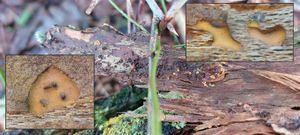

In [2]:
import pandas as pd
from pathlib import Path
from PIL import Image
import yaml

root = "~/scratch/fungiclef-2025"
! ls {root}/raw

image_root = (
    Path(root).expanduser() / "raw" / "images" / "FungiTastic-FewShot" / "test" / "300p"
)
train_metadata_path = list(Path(root).expanduser().glob("raw/metadata/*/*Train.csv"))[0]
test_metadata_path = list(Path(root).expanduser().glob("raw/metadata/*/*Test.csv"))[0]

train_df = pd.read_csv(train_metadata_path)
display(train_df.shape)
test_df = pd.read_csv(test_metadata_path)
display(test_df.shape)
row = test_df.iloc[1]
print(yaml.safe_dump(row.to_dict(), sort_keys=False))

image = Image.open(image_root / row["filename"])
display(image)

In [3]:
from genai.query import TAXONOMY_COLUMNS, extract_taxonomy_df
from genai.query import ask_llm, get_taxonomy_children

taxonomy_df = extract_taxonomy_df(train_df)

print(taxonomy_df.kingdom.unique())

print("parent count -> num child average")
for i, parent in enumerate(TAXONOMY_COLUMNS):
    if i == len(TAXONOMY_COLUMNS) - 1:
        continue
    child = TAXONOMY_COLUMNS[i + 1]
    # number of unique values
    # average children per parent
    print(
        f"{parent}: {len(taxonomy_df[parent].unique())} -> {child}: {taxonomy_df.groupby(parent)[child].nunique().mean():.2f}"
    )

['Fungi' 'Protozoa' 'Chromista']
parent count -> num child average
kingdom: 3 -> phylum: 3.67
phylum: 11 -> class: 2.91
class: 33 -> order: 3.78
order: 124 -> family: 2.89
family: 365 -> genus: 2.66
genus: 1014 -> specificEpithet: 2.39


In [11]:
completion = ask_llm(
    row,
    image_root,
    "family",
    get_taxonomy_children(
        taxonomy_df,
        "family",
    )
)
display(completion)

{'id': 'gen-1747369227-tWYZqK4sNLJ3W7HhI54G',
 'provider': 'Google AI Studio',
 'model': 'google/gemini-2.0-flash-001',
 'object': 'chat.completion',
 'created': 1747369227,
 'choices': [{'logprobs': None,
   'finish_reason': 'stop',
   'native_finish_reason': 'STOP',
   'index': 0,
   'message': {'role': 'assistant',
    'content': '{\n  "predictions": [\n    {\n      "confidence": 4,\n      "label": "Meruliaceae"\n    },\n    {\n      "confidence": 4,\n      "label": "Irpicaceae"\n    },\n    {\n      "confidence": 3,\n      "label": "Polyporaceae"\n    },\n    {\n      "confidence": 3,\n      "label": "Fomitopsidaceae"\n    },\n    {\n      "confidence": 3,\n      "label": "Steccherinaceae"\n    },\n    {\n      "confidence": 3,\n      "label": "Hymenochaetaceae"\n    },\n    {\n      "confidence": 2,\n      "label": "Phanerochaetaceae"\n    },\n    {\n      "confidence": 2,\n      "label": "Cystostereaceae"\n    },\n    {\n      "confidence": 2,\n      "label": "Ganodermataceae"\n 

In [5]:
import json

content = json.loads(completion["choices"][0]["message"]["content"])
print(content["reason"])
pred = pd.DataFrame(content["predictions"])
display(pred)

The images show a resupinate fungus growing on dead wood, suggesting a family like Meruliaceae due to its wood-decaying habitat and morphology. Other families are also plausible, but less likely.


,confidence,label
0,4,Meruliaceae
1,3,Phanerochaetaceae
2,3,Irpicaceae
3,3,Steccherinaceae
4,2,Polyporaceae
5,2,Fomitopsidaceae
6,2,Cystostereaceae
7,2,Gloeophyllaceae
8,2,Coniophoraceae
9,2,Hymenochaetaceae


In [6]:
from genai.query import get_taxonomy_children

genus = get_taxonomy_children(
    taxonomy_df,
    "genus",
    pred.label.tolist(),
)
display(len(genus), genus[:4])

binomial = get_taxonomy_children(
    taxonomy_df,
    "specificEpithet",
    genus
)
display(len(binomial), binomial[:4])

69

['Leptoporus', 'Tylospora', 'Antrodia', 'Tretomyces']

108

['Leptoporus mollis',
 'Tylospora fibrillosa',
 'Antrodia heteromorpha',
 'Antrodia griseoflavescens']

In [ ]:
genus = get_taxonomy_children(
    taxonomy_df,
    "genus",
    pred.label.tolist(),
)
completion = ask_llm(
    row,
    image_root,
    "genus",
    genus,
)
display(completion)

In [14]:
content = json.loads(completion["choices"][0]["message"]["content"])
print(content["reason"])
pred_genus = pd.DataFrame(content["predictions"])
display(pred_genus)

The poroid hymenophore visible in the images suggests genera like Ceriporia or Antrodiella. The substrate and location are also consistent with these possibilities, although definitive identification would require microscopic examination.


,confidence,label
0,3,Ceriporia
1,3,Antrodiella
2,2,Skeletocutis
3,2,Tyromyces
4,2,Ceriporiopsis
5,1,Incrustoporia
6,1,Haploporus
7,1,Leptoporus
8,1,Fibrodontia
9,1,Crustomyces


In [18]:
binomial = get_taxonomy_children(
    taxonomy_df,
    "species",
    pred_genus.label.tolist(),
)
completion = ask_llm(
    row,
    image_root,
    "species",
    binomial,
)
display(completion)

[autoreload of genai.query failed: Traceback (most recent call last):
  File "/home/anthony/clef/fungiclef-2025/genai/.venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/anthony/clef/fungiclef-2025/genai/.venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/anthony/.local/share/uv/python/cpython-3.10.16-linux-x86_64-gnu/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/anthony/clef/fungiclef-2025/ge

ValueError: 'species' is not in list

In [17]:
content = json.loads(completion["choices"][0]["message"]["content"])
print(content["reason"])
pred_genus = pd.DataFrame(content["predictions"])
display(pred_genus)

The poroid hymenophore and substrate of decaying wood are consistent with Antrodiella or similar genera. However, without microscopic details, precise identification is challenging. Other similar looking poroid crust fungi should also be considered.


,confidence,label
0,4,Antrodiella semisupina
1,3,Antrodiella leucoxantha
2,3,Ceriporia mellita
3,2,Ceriporiopsis mucidus
4,2,Antrodia heteromorpha
5,2,Skeletocutis subincarnata
6,1,Ceriporia aurantiocarnescens
7,1,Crustomyces expallens
8,1,Antrodia macra
9,1,Fibrodontia gossypina
